# DS7331 - Project 2
Adam Canton  
Matt Sherga  
Neil Benson  

# Data Preparation Part 1

###  Import Libraries and Alias

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression, SGDClassifier
from dataframe_column_identifier import DataFrameColumnIdentifier
from sklearn.utils import shuffle
from sklearn.svm import SVC
import time
import warnings

warnings.filterwarnings('ignore')

In [10]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Data Initiation

In [11]:
# Data Init
url="https://raw.githubusercontent.com/bensonnd/msds/master/ds7331/data/hotel_bookings.csv"
hotel = pd.read_csv(url)

### New Features

In [12]:

#add `arrival_date` - converting arrival y/m/d columns to a singular column
hotel['arrival_date'] = pd.to_datetime([f'{y}-{m}-{d}' for y, m, d in zip(hotel.arrival_date_year,
                                                                          hotel.arrival_date_month,
                                                                          hotel.arrival_date_day_of_month)])

    # source:
    # https://stackoverflow.com/questions/54487059/pandas-how-to-create-a-single-date-column-from-columns-containing-year-month

# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas

    
# add `departure_date` 
hotel['departure_date'] = hotel['arrival_date'] + length


# add `total_revenue`
hotel["total_revenue"] = abs(hotel["adr"]) * hotel["length_of_stay"]


# add `country_cancelation_rate`
    # first we aggregate number of cancelations per country, then divide by total records per country
    # once we have the rate, we join back on country name
hotel['is_canceled_int'] = pd.to_numeric(hotel['is_canceled'])

contry_cancellation_rate_df = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].count())

contry_cancellation_rate_df.columns = ['country_count']
contry_cancellation_rate_df['cancelations'] = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].sum())

contry_cancellation_rate_df['country_cancelation_rate'] = contry_cancellation_rate_df['cancelations'] / contry_cancellation_rate_df['country_count']

hotel = hotel.join(contry_cancellation_rate_df, on='country')

total_cancelations = hotel.is_canceled_int.sum()


# add `stays_in_week_nights_bool` and `stays_in_weekend_nights`
# by changing `stays_in_week_nights` and `stays_in_weekend_nights` to Boolean
hotel['stays_in_week_nights_bool'] = np.where(hotel['stays_in_week_nights']>0, 1, 0)
hotel['stays_in_weekend_nights_bool'] = np.where(hotel['stays_in_weekend_nights']>0, 1, 0)


# add `company_booking_bool` by changing `company` to Boolean
hotel['company'] = hotel['company'].fillna(0)
hotel['company_booking_bool'] = np.where(hotel['company']>0, 1, 0)


# add `used_agent_bool` by changing `agent` to Boolean
hotel['agent'] = hotel['agent'].fillna(0)
hotel['used_agent_bool'] = np.where(hotel['agent']>0, 1, 0)


# add `right_room_bool`
hotel['right_room_bool'] = np.where((hotel['reserved_room_type'].astype(str)==hotel['assigned_room_type'].astype(str)), 1, 0)


# add `previously_canceled_bool` by changing `previous_cancellations` to Boolean
hotel['previously_canceled_bool'] = hotel['previous_cancellations'].astype(bool).astype(int)


# add `lead_time_cat` by descretizing `lead_time`
    # `lead_time` categories 0 days to 1 week, 1 week to 1 month, 1 month to 6 months, greater than 6 months
hotel['lead_time_cat'] = pd.cut(hotel['lead_time'], bins=[0,7,31,180,737],
                labels=['booked_wk_out', 'booked_mnth_out', 'booked_6_mnths_out', 'booked_long'])


# add `country_group_cat` changed to top_ten and other_country by grouping the top 10 countries, and all others
hotel['country_group_cat'] = hotel['country'].apply(lambda x: 'top_ten' 
                                                      if x in ['PRT','GBR','BEL', 'NLD', 'DEU','ESP', 'ITA', 'IRL', 'BRA', 'FRA'] 
                                                      else 'other_country')


# add `parking_space_required_bool` by changing `required_car_parking_spaces` to Boolean
hotel['parking_space_required_bool'] = np.where(hotel['required_car_parking_spaces']>0, 1, 0)

### Dropping Redundant or Unneeded Attributes

In [13]:
# drop the unneeded temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)

In [14]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   arrival_date_week_number        119390 non-null  int64         
 3   adults                          119390 non-null  int64         
 4   children                        119386 non-null  float64       
 5   babies                          119390 non-null  int64         
 6   meal                            119390 non-null  object        
 7   market_segment                  119390 non-null  object        
 8   distribution_channel            119390 non-null  object        
 9   is_repeated_guest               119390 non-null  int64         
 10  previous_bookings_not_canceled  119390 non-null  int64  

### Finding Missing Values

In [15]:
hotel.columns[hotel.isnull().any()].tolist()

['children', 'country_cancelation_rate', 'lead_time_cat']

### Handling Missing Values

In [16]:
# replacing missing values for categorical attributes to 'Unknown'
cat_cols = ['lead_time_cat']
hotel[cat_cols] = hotel[cat_cols].replace({np.nan:'Unknown'})

# replacing missing values for continuous attributes to 0
con_cols = ['children', 'country_cancelation_rate']
hotel[con_cols] = hotel[con_cols].replace({np.nan:0})

    # Source:
    # https://stackoverflow.com/questions/45416684/python-pandas-replace-multiple-columns-zero-to-nan                                  

In [17]:
# missing columns sanity check
assert len(hotel.columns[hotel.isnull().any()].tolist()) == 0  

### Checking for duplicates

In [18]:
#check for duplicate rows
dups = hotel.duplicated().sum()

    # source:
    # https://stackoverflow.com/questions/35584085/how-to-count-duplicate-rows-in-pandas-dataframe

In [19]:
f"{round(dups/len(hotel)*100,2)}% of all records are considered duplicates"

'27.2% of all records are considered duplicates'

This is a lot. However, the data has been scrubbed any sort of granularity related to the customer attached to each booking, such as an ID or even loyaltly tier. We will assume that duplicates are simply representations of multiple bookings by different customers on the same day, and proceed without removing the duplicates.

In [20]:
#check for duplicate columns
hotel.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

### Use Proper Variable Representations

In [21]:
# converting these columns to string type
hotel[cat_cols] = hotel[cat_cols].astype(str)

# converting `babies` to int since you can't have a half a baby
hotel['babies'] = hotel['babies'].astype(int)
hotel['children'] = hotel['children'].astype(int)

#make all adr (average daily rate) values positive. (only one is actually negative)
hotel['adr'] = hotel['adr'].abs()

# list of continuous attributes
hotel_continuous = ['arrival_date_week_number','adults','children',
                    'babies','is_repeated_guest','previous_bookings_not_canceled',
                    'booking_changes','days_in_waiting_list','adr','total_of_special_requests',
                    'length_of_stay','total_revenue','country_cancelation_rate']

# hotel df of continuos variables in the data set
hotelCont = hotel[hotel_continuous]


# list of categorical attributes
hotel_categoricals =  ['hotel','is_canceled','meal','market_segment','distribution_channel',
                       'reserved_room_type','assigned_room_type','deposit_type','customer_type',
                       'stays_in_week_nights_bool','stays_in_weekend_nights_bool',
                       'company_booking_bool','used_agent_bool','right_room_bool','previously_canceled_bool',
                       'lead_time_cat','country_group_cat','parking_space_required_bool']

# setting categoricals as that type.
for cat in hotel_categoricals:
  hotel[cat] = hotel[cat].astype('category')


# hotel df of categorical variables
hotelCats = hotel[hotel_categoricals]


# converting reservation_status_date to datetime
hotel['reservation_status_date'] = pd.to_datetime(hotel['reservation_status_date'])


# hotel df of datetime variables
hotelDates = hotel.select_dtypes(include=['datetime64'])

### Identifying and Removing Outliers

In [22]:
#######################################
#
# Normalized the entire data set here only to identify and remove outliers. We'll later split the data prior to scaling, and
# and will then normalize the test and training splits separately to avoid data snooping.
#
#######################################

# Mean Normalization of the Continous Variables -  still contains large outliers pictured in graphs below
hotelCont_mean_normed = (hotelCont-hotelCont.mean())/(hotelCont.std())

# Removing outliers greater than 5 standard deviations away
hotel_nol = hotelCont_mean_normed[(np.abs(hotelCont_mean_normed) < 5).all(axis=1)]


# Grabbing indices of the non-outlier rows
no_outlier_indices = pd.DataFrame(hotel_nol.index)
no_outlier_indices.rename(columns={0: "indices"}, inplace=True)
# no_outlier_indices

# This data set has removed the outliers and un-normed the data so that we can use it without snooping on our test data
hotel_no_outliers = pd.concat([hotelCont, hotelCats], axis = 1, join = 'inner')
hotel_no_outliers = hotel_no_outliers.iloc[no_outlier_indices.indices,]

# resetting the dataframe index and dropping the extra column it creates
hotel_no_outliers.reset_index(drop=True, inplace=True)

### Define and prepare class variables

<ul>We are going to predict cancelations (`is_canceled`), either a reservation canceled or did not cancel. This is a binary response, and is categorical, so this is a classification problem.<br><br>
    `is_canceled`, our target for the classification task, was not balanced or downsampled and we did not do any adjustment/prep of the class variable specifically because we have data directly from the hotels' databases for a 3 year period; a substantially large data set. Also, this is a large enough sample that we feel it is representative of the population of the hotels' records. Aproximately 30% of the records are cancelations. Any adjustments to scaling or normalization will be addressed after we split for train/test to avoid data snooping on the full data set.</ul>
<ul>___________________________________________________________________________</ul>
  
<ul>Added new continuous variable `length_of_stay`. We will regress to this in our regression task.</ul>


```python
# add `length_of_stay`
    # we will use this as predictor in the classification task, as well as the continuous variable 
    # we want to regress to
hotel['length_of_stay'] = hotel["stays_in_weekend_nights"] + hotel["stays_in_week_nights"]


# set `length_of_stay` as a pandas time delta
length = hotel['length_of_stay'].apply(np.ceil).apply(lambda x: pd.Timedelta(x, unit='D'))

    # source:
    # https://stackoverflow.com/questions/42768649/add-days-to-date-in-pandas
```

#### Setting Data and Target

In [23]:
# classification task
data_clf = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'is_canceled']
target_clf = hotel_no_outliers['is_canceled']

# regression task
data_reg = hotel_no_outliers.loc[:, hotel_no_outliers.columns != 'length_of_stay']
target_reg = hotel_no_outliers['length_of_stay']

### One Hot Encoding Categorical Variables

In [24]:
# classification task
data_clf = pd.get_dummies(data_clf, drop_first=True)
data_clf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  int64  
 3   babies                            112151 non-null  int64  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  length_of_stay                    112151 non-null  int64  
 11  total_revenue                     112151 non-null  f

In [25]:
# regression task
data_reg = pd.get_dummies(data_reg, drop_first=True)
data_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 66 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   arrival_date_week_number          112151 non-null  int64  
 1   adults                            112151 non-null  int64  
 2   children                          112151 non-null  int64  
 3   babies                            112151 non-null  int64  
 4   is_repeated_guest                 112151 non-null  int64  
 5   previous_bookings_not_canceled    112151 non-null  int64  
 6   booking_changes                   112151 non-null  int64  
 7   days_in_waiting_list              112151 non-null  int64  
 8   adr                               112151 non-null  float64
 9   total_of_special_requests         112151 non-null  int64  
 10  total_revenue                     112151 non-null  float64
 11  country_cancelation_rate          112151 non-null  f

### Use Pre-processing methods for dimensionality reduction, scaling, etc.

#### Splitting the Data for Validation
We slit the data into test and training sets prior to scaling to avoid data snooping.

In [26]:
#setting a global number of jobs for parallel processing in the rest of the notebook
nj = -1

Using `StratifiedShuffleSplit` to split into train and test sets to maintain class balance for classification task.

In [27]:
# classification task
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

# setting the data and targets to numpy arrays
data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training and test sets
for train_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_data_clf, test_data_clf = data_Array_clf[train_index], data_Array_clf[test_index]
    train_target_clf, test_target_clf = target_Array_clf[train_index], target_Array_clf[test_index]

Without the need to maintain class balance in a regression test, we are simply splitting test and train data sets using `train_test_split`

In [28]:
# regression task
train_data_reg, test_data_reg, train_target_reg, test_target_reg = train_test_split(data_reg, 
                                                                                    target_reg, 
                                                                                    test_size=0.2, 
                                                                                    train_size=0.8, 
                                                                                    random_state=24)

#### Scaling the Data
Keeping our test and training sets separate and scaling them independently will help us avoid data snooping.

In [29]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()


# classification Task
# Train and Test Sets
scl_clf = scl.fit(train_data_clf)

# scaling the training set
train_data_clf = scl_clf.transform(train_data_clf)

# scaling the test set
test_data_clf = scl_clf.transform(test_data_clf)


# regression Task  - 
# Train and Test Sets
scl_reg = scl.fit(train_data_reg)

# scaling the training and validation set
train_data_reg = scl_reg.transform(train_data_reg)

# scaling the test set
test_data_reg = scl_reg.transform(test_data_reg)

Forming into dataframes and renaming

In [30]:
# classification task
# training set 
training_data_clf = pd.DataFrame(train_data_clf, columns = data_clf.columns)
training_target_clf = pd.DataFrame(train_target_clf, columns = ['is_canceled'])

# test set
test_data_clf = pd.DataFrame(test_data_clf, columns = data_clf.columns)
test_target_clf = pd.DataFrame(test_target_clf, columns = ['is_canceled'])

# regression task
# training set 
training_data_reg = pd.DataFrame(train_data_reg, columns = data_reg.columns)
training_target_reg = pd.DataFrame(train_target_reg, columns = ['length_of_stay'])
                                   
# test set                                 
test_data_reg = pd.DataFrame(test_data_reg, columns = data_reg.columns)
test_target_reg = pd.DataFrame(test_target_reg, columns = ['length_of_stay'])


### Dimensionality Reduction - Removing Variables that are Not Needed/Useful for Analysis
When looking at the source data, we don't see a lot of highly correlated variables and because of this, we will not be using PCA for dimensionality reduction.

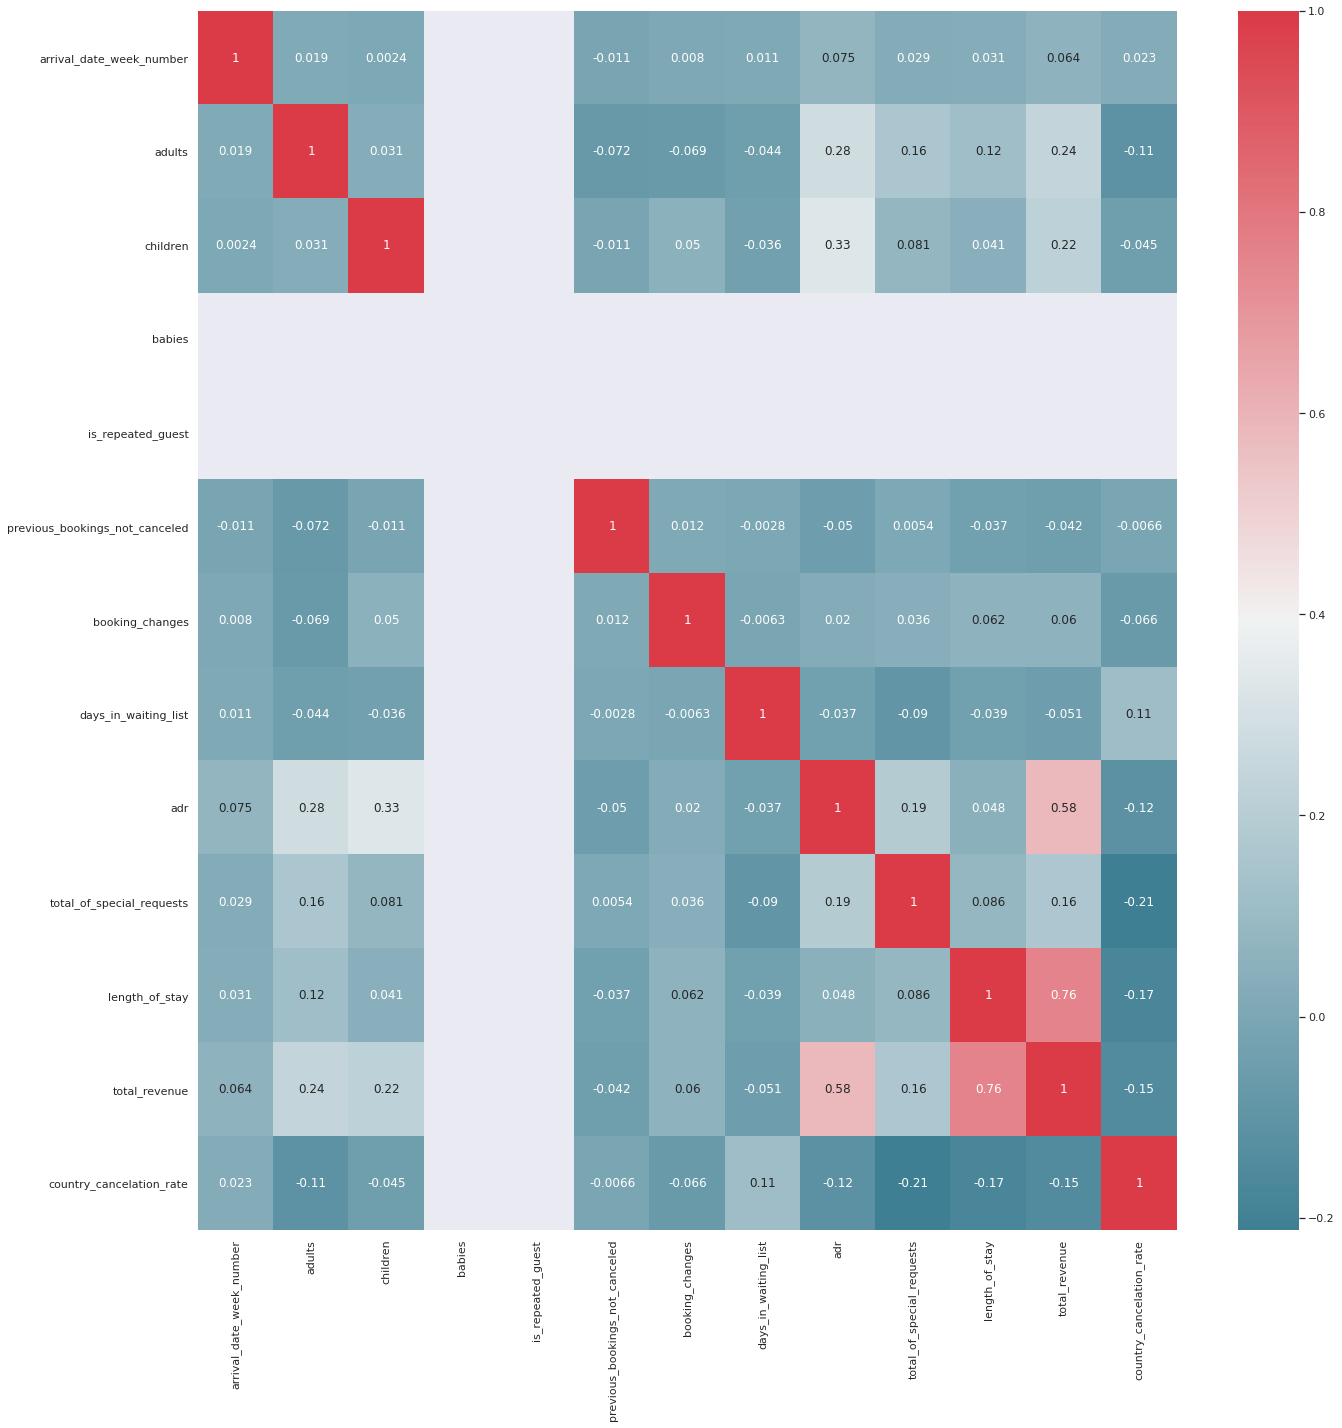

In [31]:
# plot the correlation matrix using seaborn

sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(hotel_no_outliers[hotel_continuous].corr(), cmap=cmap, annot=True)

f.tight_layout()

    # source:
    # copied from asynch notebook

Correlation Matrix:

The correlations matrix plot using the source data sans outliers tells us that there are not many strong relationships between the continuous features. We do observe some colinearity between `length_of_stay` and `total_revenue`, but that is because `total_revenue` is a product of `length_of_stay`. Something funky with `babies` and `is_repeated_guest` that we will later investigate. 

Now let's check out how the pairs plot looks with all the featurest to see if there are any that provide no value in separating the classes.

In [32]:
sns.set(color_codes=True)
var = list(hotel_no_outliers[hotel_continuous].columns)
sns.pairplot(full_train_df, hue='is_canceled', vars = var, palette="husl")

NameError: name 'full_train_df' is not defined

The variables `babies` and `is_repeated_guest` have empty plots on the diagonal (which means there is no class separation shown), so I'm going to remove them and check if my scores are the same.

In [33]:
# classification task

# training set 
training_data_clf = training_data_clf.drop(['babies','is_repeated_guest'], axis=1)


# test set
test_data_clf = test_data_clf.drop(['babies','is_repeated_guest'], axis=1)

After already removing the following, we will proceed without reducing or combining dimensions any further than we already have as noted below:
```python
# drop the temp columns created in order to create `country_cancelation_rate`
hotel = hotel.drop(['country_count','cancelations','is_canceled_int'], axis=1)


# dropping redundant date columns as this data is now available in `arrival_date`
hotel = hotel.drop(['arrival_date_year','arrival_date_month','arrival_date_day_of_month'], axis=1)


# dropping redundant stay length columns as this data is now available in 
# `stays_in_week_nights_cat` and `stays_in_weekend_nights_cat`
hotel = hotel.drop(['stays_in_week_nights','stays_in_weekend_nights'], axis=1)


# dropping redundant columns that changed to boolean or categorical or in grouped attributes
hotel = hotel.drop(['company','agent', 'lead_time', 'country', 
                    'previous_cancellations', 'required_car_parking_spaces'], axis=1)

# dropping redundant columns `reservation_status` as it's nearly identical to `is_canceled` - the target in classification
hotel = hotel.drop(['reservation_status'], axis=1)
```

# Data Preparation Part 2

Describe the final dataset that is used for classification/regression

In [34]:
hotel_no_outliers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112151 entries, 0 to 112150
Data columns (total 31 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   arrival_date_week_number        112151 non-null  int64   
 1   adults                          112151 non-null  int64   
 2   children                        112151 non-null  int64   
 3   babies                          112151 non-null  int64   
 4   is_repeated_guest               112151 non-null  int64   
 5   previous_bookings_not_canceled  112151 non-null  int64   
 6   booking_changes                 112151 non-null  int64   
 7   days_in_waiting_list            112151 non-null  int64   
 8   adr                             112151 non-null  float64 
 9   total_of_special_requests       112151 non-null  int64   
 10  length_of_stay                  112151 non-null  int64   
 11  total_revenue                   112151 non-null  float64 
 12  co

#### hotel (categorical): 
<ul>This data was collected from two hotels, each 
of a different type </ul>
 
- **Resort Hotel**  
- **City Hotel**  


---


#### is_canceled (categorical):
<ul>This column identifies whether the booking ended up being canceled. this will be our target for classification</ul>


- **1** - yes  
- **0** - no


---


#### lead_time_cat (categorical):
<ul>days elapsed between entering date of booking and arrival date, broken out by category</ul>

- **booked_wk_out** 
- **booked_mnth_out**
- **booked_6_mnths_out**
- **booked_long**


---


#### arrival_date_week_number (continuous):
<ul><b>week number</b> of year for arrival date</ul>


---

#### stays_in_weekend_nights_bool (categorical):
<ul>The reservation includes weekend night stays</ul>


- **1** - yes  
- **0** - no

---


#### stays_in_week_nights_bool (categorical):
<ul>The reservation includes week night stays</ul>


- **1** - yes  
- **0** - no

---


#### adults (continuous):	
<ul><b>number of adults</b>

The hotels in this dataset didn't seem to have a requirement for at least one adult. We don't have enough information to know, so 0 is considered valid here.</ul>


---


#### children (continuous):
<ul><b>number of children</b></ul>
	

---


#### babies (continuous):
<ul><b>number of babies</b></ul>
	

---


#### meal (categorical):
<ul>Type of meal booked. Categories are presented in standard hospitality meal packages:</ul> 

- **Undefined/SC** – no meal package  
- **BB** – Bed & Breakfast  
- **HB** – Half board (breakfast and one other meal – usually dinner)  
- **FB** – Full board (breakfast, lunch and dinner)


---


#### country_group_cat (categorical):
<ul>This is a binary classification - either we list the country as Top 10 or other.</ul>

- **top_ten** – If the country is in the top 10 list of counts of reservations in the data set  
- **other_country** – Not in the top 10, all others  

---


#### market_segment (categorical):
<ul>Market segment designation</ul> 

- **TA** - Travel Agents  
- **TO** - Tour Operators 


---


#### distribution_channel (categorical):
<ul>Booking distribution channel</ul>  

- **TA** - Travel Agents  
- **TO** - Tour Operators


---


#### is_repeated_guest (categorical):
<ul>Value indicating if the booking name was from a repeated guest</ul>

- **1** - repeated guest  
- **0** - not repeated guest


---


#### previously_canceled_bool (categoricals):
<ul>If the customer has been flagged as having previous cancelations</ul>

- **1** - yes  
- **0** - no


---


#### previous_bookings_not_canceled (continuous):
<ul><b>Number of previous bookings not cancelled</b> by the customer prior to the current booking</ul>


---


#### reserved_room_type (categorical):
<ul><b>Code of room type reserved</b>. Code is presented instead of designation for anonymity reasons</ul>



---


#### assigned_room_type (categorical):
<ul><b>Code for the type of room assigned</b> to the booking. Sometimes the assigned room type differs from the reserved room type due to hotel operation reasons (e.g. overbooking) or by customer request. Code is presented instead of designation for anonymity reasons</ul>


---


#### right_room_bool (categorical):
<ul>If the guest's reserved room matches their assigned room, we note them as having the right room.</ul>


- **1** - yes  
- **0** - no

---


#### booking_changes (continuous):
<ul><b>Number of changes/amendments</b> made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation</ul>


---


#### deposit_type (categorical):
<ul>Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories:</ul>

- **No Deposit** – no deposit was made  
- **Non Refund** – a deposit was made in the value of the total stay cost  
- **Refundable** – a deposit was made with a value under the total cost of stay


---


#### used_agent_bool (categorical):
<ul>Was the reservation booked by a booking agent?</ul>


- **1** - yes  
- **0** - no


---


#### company_booking_bool (categorical):
<ul>Is this a corporate booking?</ul>


- **1** - yes  
- **0** - no


---


#### days_in_waiting_list (continuous):
<ul><b>Number of days the booking was in the waiting list</b> before it was confirmed to the customer</ul>


---


#### customer_type (categorical):
<ul>Type of booking, assuming one of four categories:</ul>

- **Contract** - when the booking has an allotment or other type of contract associated to it  
- **Group** – when the booking is associated to a group  
- **Transient** – when the booking is not part of a group or contract, and is not associated to other transient booking  
- **Transient-party** – when the booking is transient, but is associated to at least other transient booking


---


#### adr (continuous):
<ul><b>Average Daily Rate</b> is defined by dividing the sum of revenue by the total number of staying nights at the booking level.

Our group assumes this is in USD, as it is not stated anywhere in the source paper. </ul>


---


#### parking_space_required_bool (categorical):
<ul>Does the guest require a parking space?</ul>


- **1** - yes  
- **0** - no


---


#### total_of_special_requests (continuous):
<ul><b>Number of special requests</b> made by the customer (e.g. twin bed or high floor)</ul>


---


#### length_of_stay (continuous):
<ul>Dervived column: This was created by our group using stays_in_weekend_nights and stays_in_week_nights. It is the <b>total number of nights</b> the guest stayed at the hotel</ul>

---

#### total_revenue (continuous):
<ul>Dervived column: The <b>total revenue derived</b> by multiplying ADR (Average Daily Rate) by Length of Stay. 

Our group assumes this is in USD.</ul>

---

#### country_cancelation_rate (continuous):
<ul>The total number of cancelations divided by the total number of reservations per country within the data set.</ul>

---



#### Source
https://www.sciencedirect.com/science/article/pii/S2352340918315191

# Modeling and Evaluation 1

#### Choose and explain your evaluation metrics you will use. Why are the measure(s) appropriate for analyzing the results of your modeling? Give a detailed explanation backing up any assertions.

> For our classification task, the target variable of cancelations versus non-cancelations is unbalanced (~30/70) so it will be a better choice to use F1 score, the harmonic mean of Recall and Precision and is a better measure of the incorrectly classified cases. Incorrect classifications are important and would potentially lead to booking conflicts at the hotel. Our final decision metric will be AUC on the ROC chart.

> For our regression task we are going to predict length of stay (length_of_stay). We chose regression because the number of nights guests stayed at the hotel length_of_stay is a continous variable.   We will compare against the metrics of RMSE to analyze the performance of the models because this metric penalizes large errors in the model (due to squaring first) and having a large error on a predicted length of stay may be catastrophic to the businesses uses of the model. 

# Modeling and Evaluation Part 2

#### Choose the method you will use for dividing your data into training and testing splits (i.e., are you using Stratified 10-fold cross validation? Why?) Explain why your chosen method is appropriate or use more than one method as appropriate.

For classification, we will measure the effectiveness of our models by using `StratifiedShuffleSplit` to split between training and test sets, and we will us `StratifiedKFold` with 10-fold cross validation for each fold. The count of cancelations versus non-cancelations is unbalanced (~30/70) and we want to make sure that each split and fold maintains the same balance as the source data.


For regression, we will measure the effectiveness of our models by using `train_test_split` to split between training and test sets, and we will us `KFold` with 10-fold cross validation for each fold.


Splitting the data is as follows:
```python
# classification task
# using StratifiedShuffleSplit to split into train and test sets to maintain class balance for classification task.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, train_size=0.8, random_state=24)

data_Array_clf, target_Array_clf = data_clf.to_numpy(), target_clf.to_numpy()

# split into training and test sets
for train_index, test_index in sss.split(data_Array_clf, target_Array_clf):
    train_data_clf, test_data_clf = data_Array_clf[train_index], data_Array_clf[test_index]
    train_target_clf, test_target_clf = target_Array_clf[train_index], target_Array_clf[test_index]
    
# regression task
train_data_reg, test_data_reg, train_target_reg, test_target_reg = train_test_split(data_reg, 
                                                                                    target_reg, 
                                                                                    test_size=0.2, 
                                                                                    train_size=0.8, 
                                                                                    random_state=24)

```

Setting CV objects for each task. Normally, we would be running 10 fold cv minimum, but we messed up by fitting to the wrong data set, and need to re-run and re-fit all our models on a large data set, so we've bumped this down to 3 in the interest of time and computing power. 

In [84]:
from sklearn.model_selection import KFold, StratifiedKFold

# classification task
cv_clf = StratifiedKFold(n_splits=10, shuffle=True, random_state=24)

# regression task
cv_reg = KFold(n_splits=10, random_state=24)

# Modeling and Evaluation 3

In [85]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import NearestCentroid
from numpy import arange
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

Create three different classification/regression models for each task (e.g., random forest, KNN, and SVM for task one and the same or different algorithms for task two). 

Adjust parameters as appropriate to increase generalization performance using your chosen metric. You must investigate different parameters of the algorithms!

## Classification Task: KNN, Nearest Centroid, NaiveBayes, & Decision Tree Models

We will use Gridsearch CV to tune the hyperparameters of each model. The CV object passed to the gridsearch for each regressor is the StratifiedKFold `cv_clf` object. We need a stratified cv object for our classification models because our target is categorical, and unbalanced. Once the hyperparameters have been tuned, the best estimator according to the gridsearch is fitted to the training data and scored -  by f1 -  on the test set. The best model will be selected by taking the one with the highest AUC of the ROC curve.

### KNN - Classification
Note - attempted to gridsearch `weights` and `algorithm` but due to computing and time constraints have set them manually.

In [39]:
time.time()
start_time = time.time()

clf_knn = KNeighborsClassifier(weights='distance', algorithm='auto', n_jobs=nj)

# setting the parameters
grid = {}
grid['n_neighbors'] = [i for i in range(1,12,2)]

# define search
search_f1 = GridSearchCV(clf_knn, grid, scoring='f1', cv=cv_clf, n_jobs=nj, verbose=1)

# perform the search
results_f1_knn = search_f1.fit(training_data_clf, training_target_clf.values.ravel())


# summarize the results
print('Mean f1: %.3f' % results_f1_knn.best_score_)
print('Config f1: %s' % results_f1_knn.best_params_)


print(f'Best estimator: {results_f1_knn.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')   

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.7s


Mean f1: 0.634
Config f1: {'n_neighbors': 1}
Best estimator: KNeighborsClassifier(n_jobs=-1, n_neighbors=1, weights='distance')

Time to run 44.2648 Seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   44.1s finished


Setting the parameters for the knn model based on F1 score

In [40]:
clf_knn = results_f1_knn.best_estimator_

### Nearest Centroid

Another classification method branching off KNN is nearest centroid. Let's see how it performs.

In [41]:
time.time()
start_time = time.time()

clf_nearest_cent = NearestCentroid()

# setting the parameters
grid = {}
grid['shrink_threshold'] = arange(0, .01, .1)
grid['metric'] = ['euclidean','manhattan','cosine']

# define search
search_f1 = GridSearchCV(clf_nearest_cent, grid, scoring='f1', cv=cv_clf, n_jobs=nj, verbose=1)

# perform the search
results_f1_nc = search_f1.fit(training_data_clf, training_target_clf.values.ravel())

# summarize the results
print('Mean f1: %.3f' % results_f1_nc.best_score_)
print('Config f1: %s' % results_f1_nc.best_params_)

print(f'Best estimator: {results_f1_nc.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Mean f1: 0.710
Config f1: {'metric': 'cosine', 'shrink_threshold': 0.0}
Best estimator: NearestCentroid(metric='cosine', shrink_threshold=0.0)

Time to run 1.5952 Seconds


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.4s finished


The best distance metric for both variations of our nearest centroid models is euclidean based on accuracy, with a shrink threshold of 0. The best distance metric for both variations of our nearest centroid models is cosine based on f1 score, with a shrink threshold of 0. 

Setting the parameters for the nearest centroid model based on F1 score

In [42]:
clf_nearest_cent = results_f1_nc.best_estimator_

### Gaussian Naive Bayes

Since we scaled our data using mean/stddev with StandardScaler(), our results contained some negative values. Gaussian Naive Bayes is the only NB implementation possible here, given that we have negative values. Naive Bayes is worth taking a look at, considering how little correlation there seems to be among the variables in our dataset. We found it surprising that there is not much correlation there, but if the attributes indeed do not interact much, then NB should perform well.

In [43]:
time.time()
start_time = time.time()

clf_GNB = GaussianNB()

# setting the parameters
grid = {}
grid['var_smoothing'] = [.0001, .001, .01, .1, 1, 5, 10]

# define search
search_f1 = GridSearchCV(clf_GNB, grid, scoring='f1', cv=cv_clf, n_jobs=nj, verbose=1)

# perform the search
results_f1_nb = search_f1.fit(training_data_clf, training_target_clf.values.ravel())

# summarize the results
print('Mean f1: %.3f' % results_f1_nb.best_score_)
print('Config f1: %s' % results_f1_nb.best_params_)


print(f'Best estimator: {results_f1_nb.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 10 folds for each of 7 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s


Mean f1: 0.671
Config f1: {'var_smoothing': 1}
Best estimator: GaussianNB(var_smoothing=1)

Time to run 4.4944 Seconds


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    4.3s finished


Setting the parameters for the Naive Bayes model based on F1 score

In [44]:
clf_GNB = results_f1_nb.best_estimator_

### Decision Tree

In [45]:
#Decision Tree classifier, including hyperparameter tuning
time.time()
start_time = time.time()

clf_decision = tree.DecisionTreeClassifier()

# setting the parameters
grid = {}
grid['criterion'] = ['gini', 'entropy']
grid['splitter'] = ['best', 'random']
grid['max_features'] = ['auto', 'sqrt', 'log2']

# define search
search_f1 = GridSearchCV(clf_decision, grid, scoring='f1', cv=cv_clf, n_jobs=nj, verbose=1)

# perform the search
results_f1_dc = search_f1.fit(training_data_clf, training_target_clf)


# summarize
print('Mean f1: %.3f' % results_f1_dc.best_score_)
print('Config f1: %s' % results_f1_dc.best_params_)

print(f'Best estimator: {results_f1_dc.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.2s finished


Mean f1: 0.786
Config f1: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}
Best estimator: DecisionTreeClassifier(criterion='entropy', max_features='sqrt')

Time to run 7.5727 Seconds


The best performing model based on accuracy used the `'entropy'`, `'auto'`, and `'best'` hyperparameters. The best performing model based on f1 score used the `'entropy'`, `'sqrt'`, and `'best'` hyperparameters.

Setting the parameters for the decision tree model based on F1 score

In [46]:
clf_decision = results_f1_dc.best_estimator_

## Regression Task: Random Forest, OLS Ridge Regression, KNN


We will use Gridsearch CV to tune the hyperparameters of each model. The CV object passed to the gridsearch for each regressor is the KFold `cv_reg` object. We do not need a stratified cv object for our regressors because our target is continous. Once the hyperparameters have been tuned, the best estimator according to the gridsearch is fitted to the training data and scored -  by RMSE -  on the test set. The best model will be selected by taking the one with the smallest RMSE. However, other metrics such as time, need to re-train, scalability, and the trade-offs from these will also be discussed. 

The GridsearchCV is scoring using the `neg_root_mean_squared_error` or negated RMSE which is just the opposite signed RMSE. When we score the test set we are using the `np.sqrt(metrics.mean_squared_error)` to get the postive RMSE.

### Random Forest
#### Hyperparameters considered for tuning


`n_estimators`: The amount of trees created and used to estimate the target, we used 50 and 100.

`criterion`: the metric which measures the quality of a split - either mean squared error or mean absolute error.

`max depth`: the maximum number of end leaf nodes. We used 25 and 60.  

`max_features`: is the size of the random subsets of features to consider when splitting a node.

Note - we could have added `criterion` into our gridsearch, but opted to manually set it based on previous runs and set it in the interest of time and computing power.


In [47]:
from sklearn.ensemble import RandomForestRegressor

time.time()
start_time = time.time()

# Random Forest, including hyperparameter tuning
reg_rf = RandomForestRegressor(n_jobs=nj, bootstrap=True, random_state=42, max_features='auto', criterion='mse')

# setting the parameters
grid = {}
grid['n_estimators'] = [50, 100]
# grid['criterion'] = ['mse', 'mae']
grid['max_depth'] = [25, 60]
grid['max_features'] = ['auto', 'sqrt', 'log2']


# define search
CV_rfc_reg_rf = GridSearchCV(estimator=reg_rf, param_grid=grid, cv=cv_reg,
                      scoring='neg_root_mean_squared_error', n_jobs=nj, verbose=1)

# perform the search
CV_rfc_reg_rf.fit(training_data_reg, training_target_reg.values.ravel())


# summarize
print('Mean RMSE: %.3f' % CV_rfc_reg_rf.best_score_)
print('Config: %s' % CV_rfc_reg_rf.best_params_)
print(f'Best estimator: {CV_rfc_reg_rf.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.0min


KeyboardInterrupt: 

Setting the parameters for the Random Forest model based on RMSE  
Previous runs that included `criterion` produced: 
```python
{'criterion': 'mse', 'max_depth': 25, 'max_features': 'auto', 'n_estimators': 100}
```

In [36]:
reg_rf = CV_rfc_reg_rf.best_estimator_

In [37]:
# Get predictions
yhat_rf = reg_rf.predict(training_data_reg)

rmse_rf = np.sqrt(metrics.mean_squared_error(training_target_reg, yhat_rf))

# Results of Best estimator for Random Forest
print("RMSE is:", rmse_rf)

RMSE is: 0.05051033855511083


### OLS Ridge Regression
#### Hyperparameters considered for tuning


`alpha`: Regularization strength. Larger values are stronger. Reduces varaiance in estimates

`solver`: What equation or algorithm the ridge will use:

    svd: Singular Value Decomposition 
    cholesky: uses linalg functions to obtain a close formed solution 
    lsqr: regularized least squares - usually fastest, uses and iterative procedure  
    sparse_cg: Conjugate Gradient Solver, better for large scale data  
    auto: method auto determined by data  
    saga: Stochastic Average Gradient Descent with L1 regularization support  

In [48]:
time.time()
start_time = time.time()


# OLS Ridge Regression, including hyperparameter tuning
reg_ols = Ridge(random_state=42)

# setting the parameters
grid = {}
grid['alpha'] = [.001, .01, .1, 1, 5, 10, 100, 1000]
grid['solver'] = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'auto', 'saga']


# define search
CV_rfc_reg_ols = GridSearchCV(estimator=reg_ols, param_grid=grid, cv=cv_reg,
                      scoring='neg_root_mean_squared_error', n_jobs=nj, verbose=1)

# perform the search
CV_rfc_reg_ols.fit(training_data_reg, training_target_reg)


# summarize
print('Mean RMSE: %.3f' % CV_rfc_reg_ols.best_score_)
print('Config: %s' % CV_rfc_reg_ols.best_params_)
print(f'Best estimator: {CV_rfc_reg_ols.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 10 folds for each of 48 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min


Mean RMSE: -0.884
Config: {'alpha': 10, 'solver': 'cholesky'}
Best estimator: Ridge(alpha=10, random_state=42, solver='cholesky')

Time to run 117.8166 Seconds


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.0min finished


Setting the parameters for the OLS Ridge Regression model based on RMSE

In [49]:
reg_ols = CV_rfc_reg_ols.best_estimator_

In [50]:
# Get predictions
yhat_ols = reg_ols.predict(training_data_reg)

rmse_ols = np.sqrt(metrics.mean_squared_error(training_target_reg, yhat_ols))

# Results of Best estimator for OLS Ridge Regression
print("RMSE is:", rmse_ols)

RMSE is: 0.8837698897077488


### KNN - Regression
#### Hyperparameters considered for tuning


`algorithm`: The computing process employed by the KNN regressor.  

    Auto 
    ball_tree 
    kd_tree  

`weights`: How points in the neighborhood are weighted
   
   <ul><li>uniform: all points in the neighborhood recieve equal weight regardless of distance.</li>  
   <li>distance: all points in the neighborhood are weighted by distance away from the observation in question. Closer points weigh more.</li></ul>  
    
`n_neighbors`: How many points to include in each neighborhood. 

Note - attempted to gridsearch `weights` and `algorithm` but due to computing and time constraints have set them manually.

Previous runs that included `weights` and `algorithm` produced: 
```python
{'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'distance'}
```

In [51]:
time.time()
start_time = time.time()


# Random Forest classifier, including hyperparameter tuning
reg_knn = KNeighborsRegressor(n_jobs=nj, algorithm='auto', weights='distance')


# setting the parameters
grid = {}
grid['n_neighbors'] = [i for i in range(1,12,2)]

# define search
CV_rfc_reg_knn = GridSearchCV(estimator=reg_knn, param_grid=grid, cv=cv_reg,
                      scoring='neg_root_mean_squared_error', n_jobs=nj, verbose=1)

# perform the search
CV_rfc_reg_knn.fit(training_data_reg, training_target_reg)


# summarize
print('Mean RMSE: %.3f' % CV_rfc_reg_knn.best_score_)
print('Config: %s' % CV_rfc_reg_knn.best_params_)
print(f'Best estimator: {CV_rfc_reg_knn.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')


Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.3s


Mean RMSE: -1.020
Config: {'n_neighbors': 7}
Best estimator: KNeighborsRegressor(n_jobs=-1, n_neighbors=7, weights='distance')

Time to run 54.9512 Seconds


[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   54.8s finished


Setting the parameters for the KNN Regression model based on RMSE

In [52]:
reg_knn = CV_rfc_reg_knn.best_estimator_

In [53]:
# Get predictions
yhat_knn = reg_knn.predict(training_data_reg.to_numpy())

rmse_knn = np.sqrt(metrics.mean_squared_error(training_target_reg.to_numpy(), yhat_knn))

# Results of Best estimator for KNN
print("RMSE is:", rmse_knn)

RMSE is: 0.0084308702106346


# Modeling and Evaluation Part 4

Analyze the results using your chosen method of evaluation. Use visualizations of the results to bolster the analysis. Explain any visuals and analyze why they are interesting to someone that might use this model.

## Classication - ROC Curves and Confusion Matrices

### ROC
In order to plot ROC for Nearest Centroid and Decision Tree, an ensemble method called bagging must be employed to get prediction probabilities for plotting.

In [54]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()

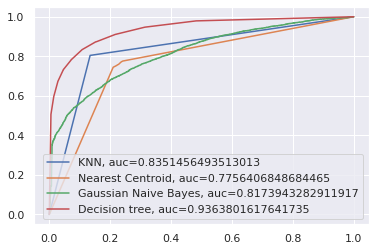

In [55]:
# plot the ROC curve on the test data for KNN for clf
clf_knn.fit(training_data_clf, training_target_clf)
Y_pred_knn_prob = clf_knn.predict_proba(test_data_clf)[::,1]
fpr_knn, tpr_knn, _ = metrics.roc_curve(test_target_clf,  Y_pred_knn_prob)
auc_knn = metrics.roc_auc_score(test_target_clf, Y_pred_knn_prob)
plt.plot(fpr_knn,tpr_knn,label="KNN, auc="+str(auc_knn))


# bagging to get probabilities for an ROC curve for Nearest Centroid
clf_bag_ncent = BaggingClassifier(base_estimator=clf_nearest_cent, random_state=24).fit(training_data_clf, training_target_clf)

# plot the ROC curve on the test data for Nearest Centroid
Y_pred_ncent_prob = clf_bag_ncent.predict_proba(test_data_clf)[::,1]
fpr_ncent, tpr_ncent, _ = metrics.roc_curve(test_target_clf,  Y_pred_ncent_prob)
auc_ncent = metrics.roc_auc_score(test_target_clf, Y_pred_ncent_prob)
plt.plot(fpr_ncent,tpr_ncent,label="Nearest Centroid, auc="+str(auc_ncent))


# plot the ROC curve on the test data for Naive Bayes
clf_GNB.fit(training_data_clf, training_target_clf)
Y_pred_GNB_prob = clf_GNB.predict_proba(test_data_clf)[::,1]
fpr_GNB, tpr_GNB, _ = metrics.roc_curve(test_target_clf,  Y_pred_GNB_prob)
auc_GNB = metrics.roc_auc_score(test_target_clf, Y_pred_GNB_prob)
plt.plot(fpr_GNB,tpr_GNB,label="Gaussian Naive Bayes, auc="+str(auc_GNB))


#bagging to get probabilities for an ROC curve for Decision Tree
clf_bag_dtree_acc = BaggingClassifier(base_estimator=clf_decision, random_state=24).fit(training_data_clf, training_target_clf)

# plot the ROC curve on the test data for Decision Tree
Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(test_data_clf)[::,1]
fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(test_target_clf,  Y_pred_dtree_acc_prob)
auc_dtree_acc = metrics.roc_auc_score(test_target_clf, Y_pred_dtree_acc_prob)
plt.plot(fpr_dtree_acc,tpr_dtree_acc,label="Decision tree, auc="+str(auc_dtree_acc))

plt.legend(loc=4) 

Above, we have the ROC curves for each of our models. As you can see, nearest centroid can hardly be called a curve and has the worst AUC of .7721. The Naive Bayes model has a surprisingly good AUC of .8208 considering the independence assumption we make, but the remaining models wipe the floor with these. KNN and Decision Tree have shockingly similar outcomes for their ROC curves, but ultimately the Decision Tree classifier wins by a narrow margin with an AUC of .9356 vs KNN's .9344. We would like to note that in order to get the probabilities for plotting their ROC curves, the ensemble BaggingClassifier had to be used on the Nearest Centroid and Decision Tree models. Achieving an AUC of .9356, we are very happy with the performance of our final model.

If it came down to picking between KNN and Decision Tree, we would opt for Decision Tree as a classification model if they had the exact same ROC curve, because KNN is computationally expensive.

### Confusion Matrices and F1 Scores

The confusion matrices below give us a nice glimpse of the prediction outcomes of each of our models. With the color gradient maxing out at yellow, we'd hope to see our true negatives (not canceled) in this color. Our true positives should be somewhere in the middle of the gradient (green-ish), considering the imbalance of our classes for this target variable. Lastly, the false positives/negatives should hopefully be as purple as it gets! We obviously don't want our errors to be very high.

KNN Confusion Matrix

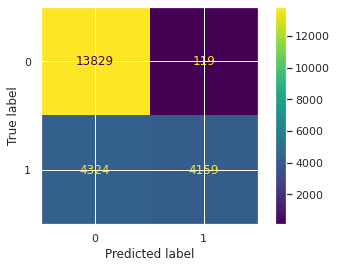

In [56]:
Y_pred_knn = clf_knn.predict(test_data_clf)
cmd(confusion_matrix(test_target_clf, Y_pred_knn)).plot()

KNN f1 score

In [57]:
start_time = time.time()

f1_clf_knn = f1_score(test_target_clf, Y_pred_knn)
print (f'Test set f1 score: {f1_clf_knn}\n')
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score: 0.6518297939032991

Time to run 0.0091 Seconds


Nearest Centroid Confusion Matrix

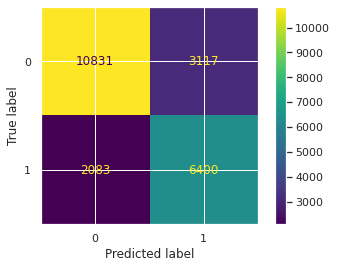

In [58]:
Y_pred_nearest_cent = clf_nearest_cent.predict(test_data_clf)
cmd(confusion_matrix(test_target_clf, Y_pred_nearest_cent)).plot()

Nearest Centroid f1 score

In [59]:
start_time = time.time()

clf_nearest_cent.fit(training_data_clf, training_target_clf)

Y_pred = clf_nearest_cent.predict(test_data_clf)

f1_clf_nearest_cent = f1_score(test_target_clf, Y_pred)
print (f'Test set f1 score: {f1_clf_nearest_cent}\n')
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score: 0.711111111111111

Time to run 0.0466 Seconds


Naive Bayes Confusion Matrix

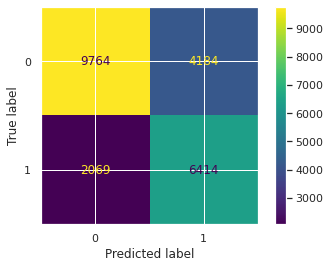

In [60]:
Y_pred_NGB = clf_GNB.predict(test_data_clf)
cmd(confusion_matrix(test_target_clf, Y_pred_NGB)).plot()

Naive Bayes f1 score

In [61]:
start_time = time.time()

Y_pred = clf_GNB.predict(test_data_clf)

f1_clf_GNB = f1_score(test_target_clf, Y_pred)
print (f'Test set f1 score: {f1_clf_GNB}\n')
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score: 0.672291808605419

Time to run 0.0223 Seconds


Decision Tree Confusion Matrix

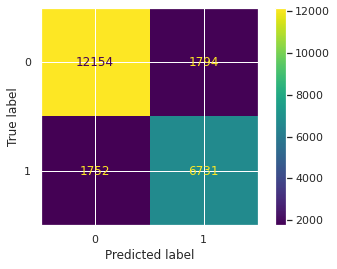

In [62]:
Y_pred_dtree = clf_decision.predict(test_data_clf)
cmd(confusion_matrix(test_target_clf, Y_pred_dtree)).plot()

Decision Tree f1 score

In [63]:
start_time = time.time()

clf_decision.fit(training_data_clf, training_target_clf)

Y_pred = clf_decision.predict(test_data_clf)

f1_clf_decision = f1_score(test_target_clf, Y_pred)
print (f'Test set f1 score: {f1_clf_decision}\n')
print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Test set f1 score: 0.7910070037078454

Time to run 0.2007 Seconds


Decision Tree Splits

Below is a very small representation of our enormous decision tree to see how the splitting initially starts. Blue boxes are 'is_canceled' as 1, and Orange boxes are 0.

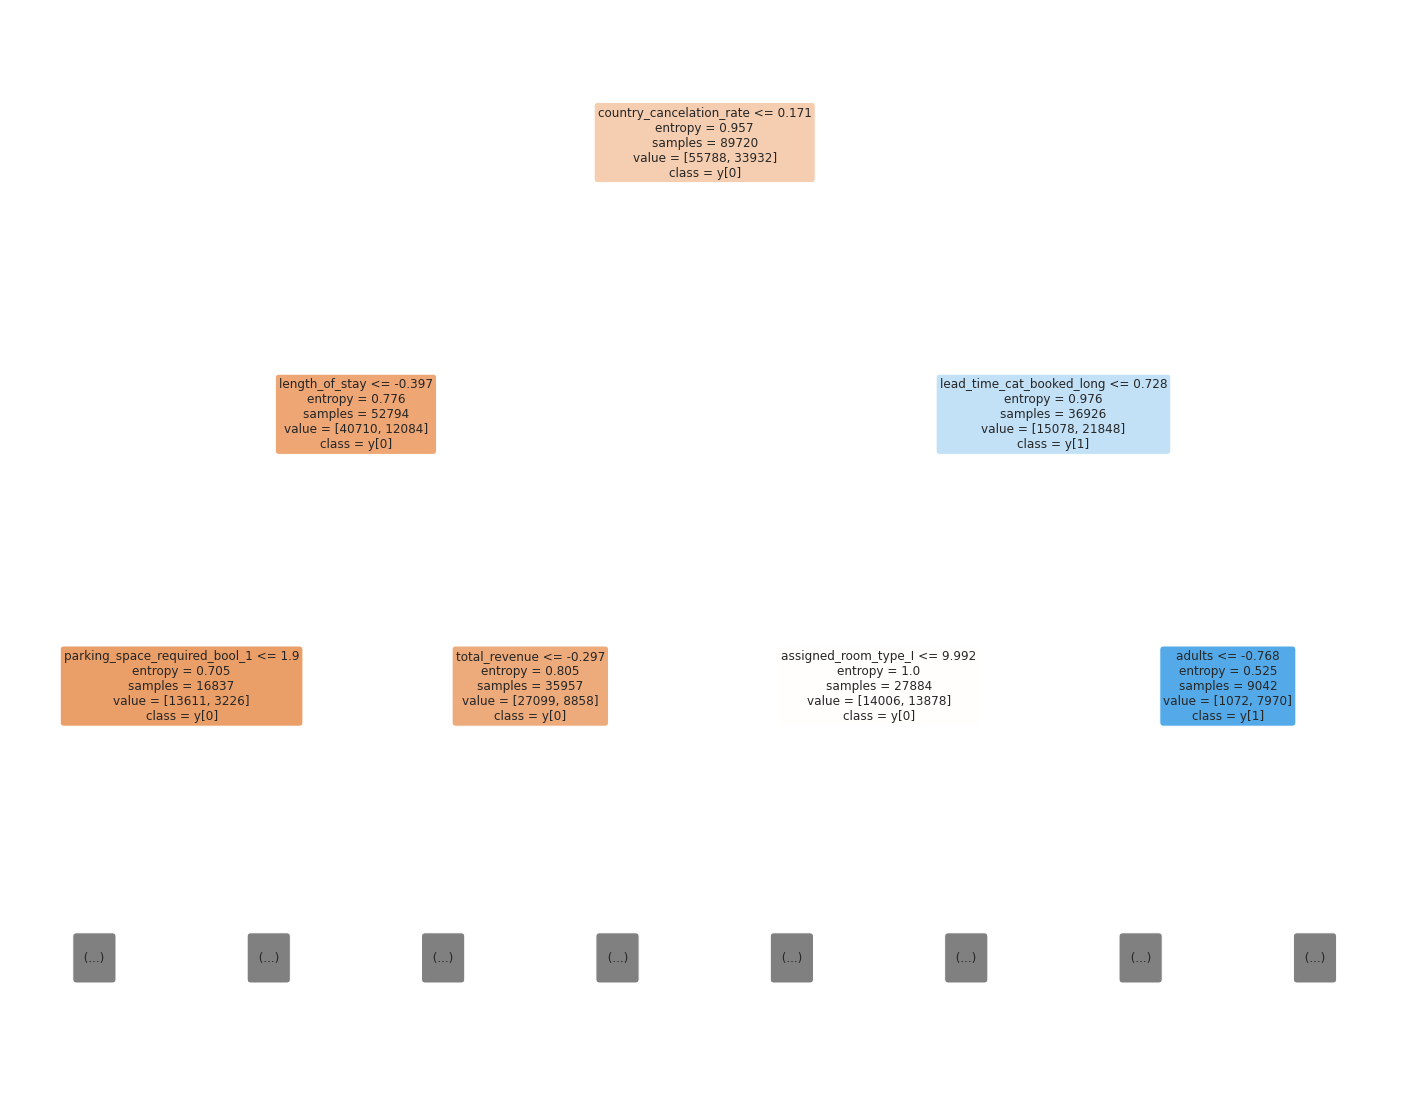

In [64]:
# sourced from https://mljar.com/blog/visualize-decision-tree/

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_decision,
                   max_depth= 2,
                   feature_names=test_data_clf.columns,  
                   class_names=True,
                   filled=True,
                  rounded = True,
                  fontsize = 12)


Let's take a look at a deeper tree and see what that looks like.

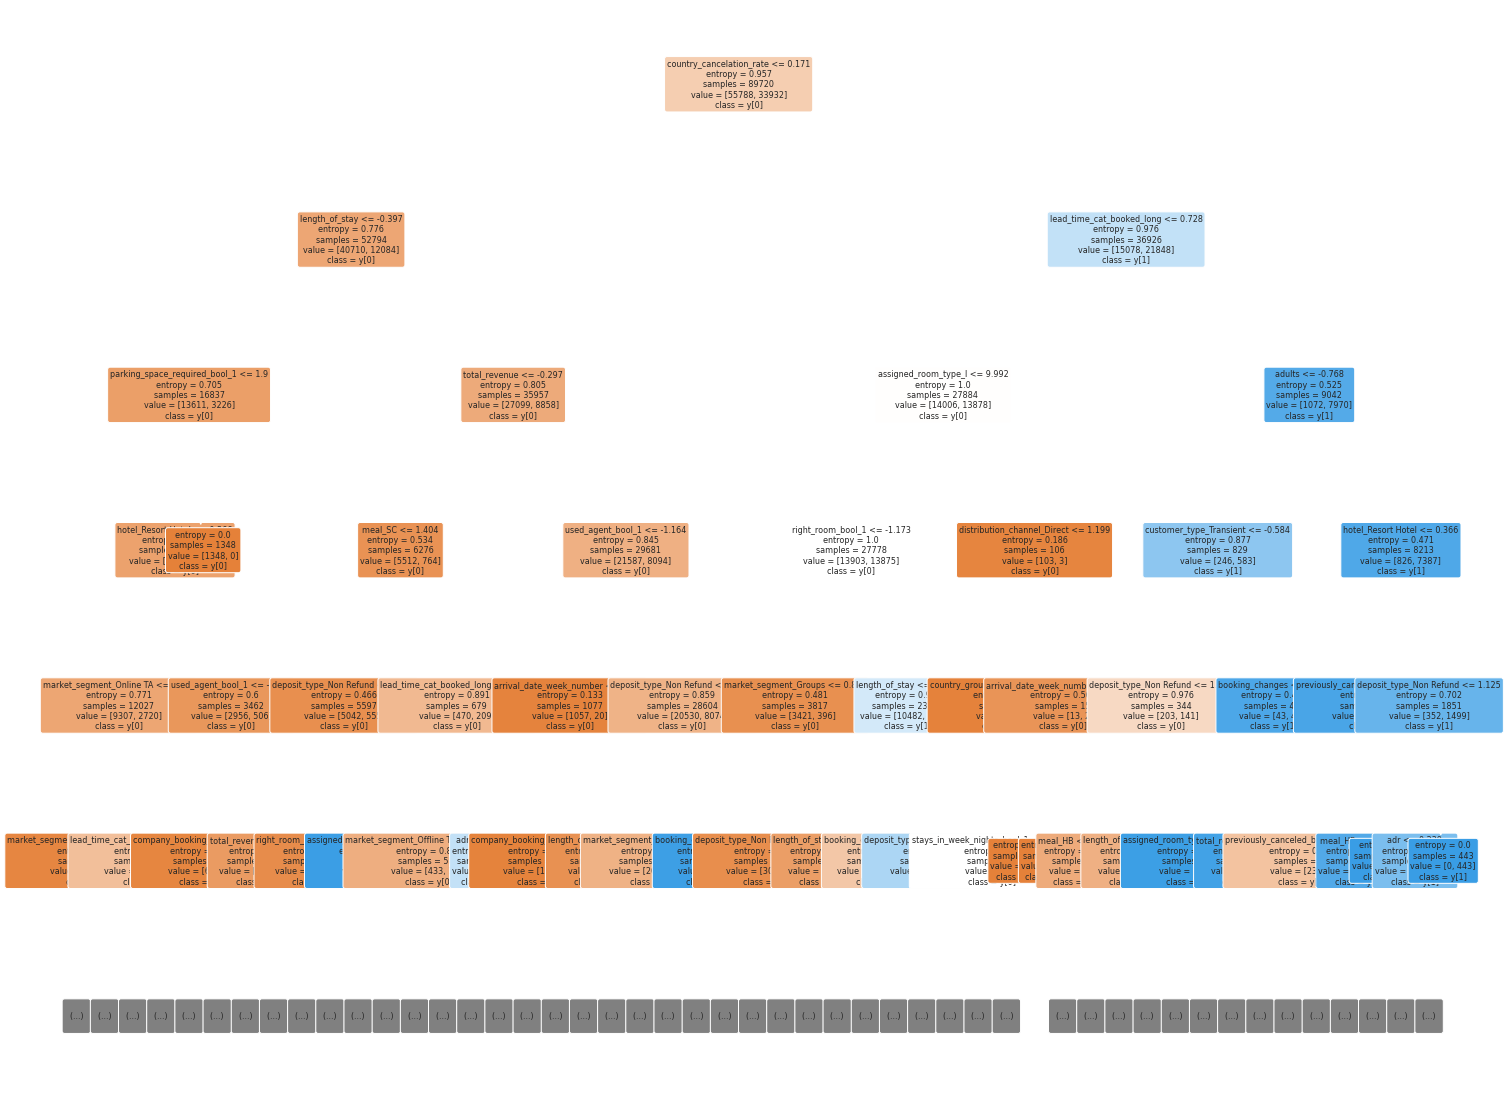

In [65]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf_decision,
                   max_depth= 5,
                   feature_names=test_data_clf.columns,  
                   class_names=True,
                   filled=True,
                  rounded = True,
                  fontsize = 8)

The tree becomes nearly impossible to fully follow starting at a depth of 5 nodes away from the root. Visually, you can already see that the distribution of the two classes is like that of the source data. The number of 'is_canceled' = 0 is nearing double that of 'is_canceled' = 1 in the source data, and the blue vs orange representation here demonstrates a similar trend. However, with our model not being 100% successful, the distribution looks to still favor the 0 value a bit more than 1. The strongest initial indicator according to this tree looks like a guest having a non-refundable deposit put down and right_room_bool_1 meaning that according to the data we have, a guest having the right room assigned to them is more likely to cancel their reservation. Without domain expertise this doesn't seem to make sense, however there may be some further data that hasn't been anonymized which could shed more light on why this is the case.

### Combining and comparing f1 scores
Creating a dataframe with all the f1 scores for all the classification models; we'll validate further down using ROC's area under the curve (AUC).

In [66]:
clf_f1_df = pd.DataFrame({
                        'model': ['knn','nearest centroid','naive bayes','decision tree'], 
                        'f1': [f1_clf_knn,f1_clf_nearest_cent,f1_clf_GNB,f1_clf_decision]}
                      )

clf_f1_df.sort_values(by='f1', ascending=False)

,model,f1
3,decision tree,0.791007
1,nearest centroid,0.711111
2,naive bayes,0.672292
0,knn,0.651830


KNN has a slightly higher f1 score than the decision tree model, but decision tree has a higher AUC.

## Regression - Random Forest, OLS Ridge Regression, KNN

### Random Forest Prediction Error Plot

In [67]:
# Getting predictions and pairing them with truth
yhat_rf_test = pd.DataFrame(reg_rf.predict(test_data_reg))
yhat_rf_test.columns = ['Predicted']
test_target_trial = test_target_reg.reset_index()
test_target_trial.drop(['index'], axis=1, inplace = True)
test_target_trial
yhat_rf_test = yhat_rf_test.join(test_target_trial)

# Graph everything
X_plot = np.linspace(0, 20, 100)
Y_plot = X_plot
sns.lmplot(x = 'length_of_stay', y = 'Predicted', data = yhat_rf_test)
plt.plot(X_plot,Y_plot, color='grey')
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted reg_rf')

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

The trend in the above Predicted vs Actual graph shows that the random forest did very well predicting length of stay. The grey line represents the line of equality where the actual and predicted match. In fact the blue regression line is completely covered by the grey line.

### OLS Ridge Regression Prediction Error Plot

Text(0.5, 1.0, 'Actual vs Predicted reg_ols')

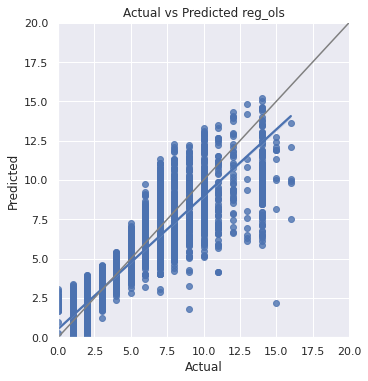

In [68]:
# Getting predictions and pairing them with truth
yhat_ols_test = pd.DataFrame(reg_ols.predict(test_data_reg))
yhat_ols_test.columns = ['Predicted']
test_target_trial = test_target_reg.reset_index()
test_target_trial.drop(['index'], axis=1, inplace = True)
test_target_trial
yhat_ols_test = yhat_ols_test.join(test_target_trial)

# Graph everything
X_plot = np.linspace(0, 20, 100)
Y_plot = X_plot
sns.lmplot(x = 'length_of_stay', y = 'Predicted', data = yhat_ols_test)
plt.plot(X_plot,Y_plot, color='grey')
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted reg_ols')

Here we can clearly see the blue regression line trend edging away from the grey line of equality. This indicates that the reg ols model does worse when predicting lengths of stay beyond about 5 days. In general beyond this point the model is underestimating most stays. Over all not a bad model, though significantly over the rest.

### KNN Prediction Error Plot

Text(0.5, 1.0, 'Actual vs Predicted reg_knn')

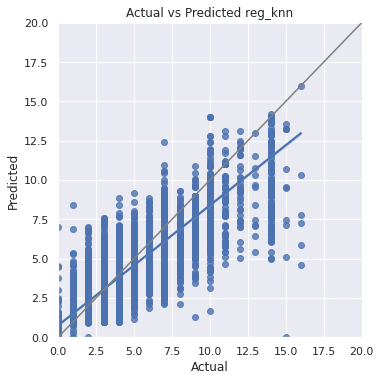

In [69]:
# Getting predictions and pairing them with truth
yhat_knn_test = pd.DataFrame(reg_knn.predict(test_data_reg))
yhat_knn_test.columns = ['Predicted']
test_target_trial = test_target_reg.reset_index()
test_target_trial.drop(['index'], axis=1, inplace = True)
test_target_trial
yhat_knn_test = yhat_knn_test.join(test_target_trial)

# Graph everything
X_plot = np.linspace(0, 20, 100)
Y_plot = X_plot
sns.lmplot(x = 'length_of_stay', y = 'Predicted', data = yhat_knn_test)
plt.plot(X_plot,Y_plot, color='grey')
plt.xlim([0,20])
plt.ylim([0,20])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted reg_knn')

Much like the reg ols model above the KNN seems to stray from the equality line, though probably a bit earlier. It seems to provide a larger underestimate than the previous models, but scored by far the best on the metric chosen. With the majority of stays being under a week, it may be that this model predicts the low end of the data much better than the others.

# Modeling and Evaluation Part 5

#### Discuss the advantages of each model for each classification task, if any. If there are not advantages, explain why. Is any model better than another?

### Classification
#### KNN
KNN's advantage in classifying the data is that it doesn't need to be trained, so since we have many variables, it's a good option for enterprise level prediction. You can just keep feeding it new data to predict on, rather than retraining it constantly. However, it does still take quite a long time to run with big amounts of data. 


#### Nearest Centroid
Nearest Centroid is somewhat similar to KNN in concept, however is exceptionally faster as it is not affected severely by data size like KNN is. It is faster because it learns the centroids (means) for the target classes, then new data that is fed into the model simply picks the class of whatever centroid is closest to it. Unfortunately if the data is noisy or has outliers, it's negatively affected because of its operation on the mean. This ended up being our worst performinf classification model.

#### Naive Bayes
Naive Bayes is another incredibly fast classifier when comparing big data prediction methods. If the NB assumption of feature independence is true, then the model should perform well. Since our correlation plot didn't indicate strong relationships between the features, it seemed like a good option to explore. That's a strong assumption to make though, and it is observed in our outcome that it didn't perform as well as the other models except for nearest centroid.

#### Decision Tree
Decision Tree is another super fast classifier, and our best performing one. It beat out KNN by a narrow margin, using AUC as our decision metric. Considering how long KNN took to run, that boosts the support we have for choosing Decision Tree. It's also simple to explain, as the idea of branching to reach a decision is easily understood by a layperson. This is partially to do with its process mirroring human decision making. Lastly, it performs very well, though there is a big risk of overfitting. They typically have very low bias, and high variance which can potentially affect their accuracy in a big way.

_____________________________________________________________________________________________________________


### Regression
#### Random Forest
The random forest model performed very well on the data. However, it was an absolute beast to fit and cross validate. The implementation of the mae criterion in sklearn apparently computes at O(N^2) making those models run for 10's of minutes a piece. The results are great, but if re-training is going to be occuring frequently and computing power is an issue this method may be out of the question.

#### OLS Ridge Regression
The OLS Ridge Regression was the antithesis of the random forest. It gridsearched and cross validated in about a minute and a half. The quickness came with a draw back in prediction error as this model had the highest rmse. However if frequent retraining will be occuring and the data set is going to be expanding then this method is great, as long as the cost of being wrong isn't prohibtively costly with the rmse loss.

#### KNN
The Knn model performed the best of all the models and was actually middle of the road in train time. Though it was much closer to the train time of the random forest than the Ols Ridge regression. The KNN suffered on the test set like the ridge regression. But managed the best rmse by a full order of magnitude.


_____________________________________________________________________________________________________________


#### Is the difference significant with 95% confidence? proper statistical comparison methods. You must use statistical comparison techniques—be sure they are appropriate for your chosen method of validation as discussed in unit 7 of the course.

### Classification
Creating a dataframe with all the AUC scores for all the classification models

In [70]:
clf_auc_df = pd.DataFrame({
                        'model': ['knn','nearest centroid','naive bayes','decision tree'], 
                        'AUC': [auc_knn,auc_ncent,auc_GNB,auc_dtree_acc]}
                      )

clf_auc_df.sort_values(by='AUC', ascending=False)

,model,AUC
3,decision tree,0.936380
0,knn,0.835146
2,naive bayes,0.817394
1,nearest centroid,0.775641


Because the Decision Tree for classification has the highest area under the curve in an ROC curve, we will move forward with this model for classification.

### Regression
Using paired_ttest_5x2cv toc compare generate statistics on the difference in model performance.

In [71]:
%%time

from mlxtend.evaluate import paired_ttest_5x2cv

# Comparing Random Forest and OLS
t, p = paired_ttest_5x2cv(estimator1=reg_rf,
                         estimator2=reg_ols,
                         X=test_data_reg, y=test_target_reg,
                         scoring='neg_mean_squared_error',
                         random_seed=42) 

print('t statistic: %.3f' % t)
print('p value: %.7f' % p)

t statistic: 21.422
p value: 0.0000041
CPU times: user 27.4 s, sys: 4.93 s, total: 32.4 s
Wall time: 6.77 s


In [72]:
print('Null hypothesis: RMSE(rf) = RMSE(ols)')
print(f'Reject null hypothesis with a critical test statistic of {t:.2f} and p-value of {p:.4f} < .05')

Null hypothesis: RMSE(rf) = RMSE(ols)
Reject null hypothesis with a critical test statistic of 21.42 and p-value of 0.0000 < .05


In [73]:
%%time
# Comparing OLS and KNN
t, p = paired_ttest_5x2cv(estimator1=reg_ols,
                         estimator2=reg_knn,
                         X=test_data_reg, y=test_target_reg,
                         scoring='neg_mean_squared_error',
                         random_seed=42) 

print('t statistic: %.3f' % t)
print('p value: %.7f' % p)

t statistic: 18.476
p value: 0.0000085
CPU times: user 9.96 s, sys: 4.95 s, total: 14.9 s
Wall time: 2.37 s


In [74]:
print('Null hypothesis: RMSE(ols) = RMSE(knn)')
print(f'Reject null hypothesis with a critical test statistic of {t:.2f} and p-value of {p:.4f} < .05')

Null hypothesis: RMSE(ols) = RMSE(knn)
Reject null hypothesis with a critical test statistic of 18.48 and p-value of 0.0000 < .05


In [75]:
%%time
# Comparing KNN and Random Forest
t, p = paired_ttest_5x2cv(estimator1=reg_knn,
                         estimator2=reg_rf,
                         X=test_data_reg, y=test_target_reg,
                         scoring='neg_mean_squared_error',
                         random_seed=42) 

print('t statistic: %.3f' % t)
print('p value: %.7f' % p)

t statistic: -21.495
p value: 0.0000040
CPU times: user 32 s, sys: 0 ns, total: 32 s
Wall time: 8.29 s


In [76]:
print('Null hypothesis: RMSE(knn) = RMSE(rf)')
print(f'Reject null hypothesis with a critical test statistic of {t:.2f} and p-value of {p:.4f} < .05')

Null hypothesis: RMSE(knn) = RMSE(rf)
Reject null hypothesis with a critical test statistic of -21.49 and p-value of 0.0000 < .05


Creating a dataframe for comparing RMSE for all the regression models

In [77]:
reg_rmse_df = pd.DataFrame({
                        'model': ['random forest', 'ols ridge regression','knn'], 
                        'RMSE': [rmse_rf, rmse_ols, rmse_knn]}
                      )

reg_rmse_df.sort_values(by='RMSE', ascending=True)

NameError: name 'rmse_rf' is not defined

And the best regression model is KNN based on lowest RMSE.

# Modeling and Evaluation Part 6

Which attributes from your analysis are most important? Use proper methods discussed in class to evaluate the importance of different attributes. Discuss the results and hypothesize about why certain attributes are more important than others for a given classification task.  

### Feature Selection - Classification
We will use a RandomForest and RFECV for classification for feature selection. For this, we will use `roc_auc` scoring.

In [78]:
#import the functions and fit to the training set
start_time = time.time()

# Classification Task
rfecv_clf = RFECV(clf_decision,
              cv=cv_clf, 
              scoring = 'roc_auc',
              n_jobs=nj)
    


rfecv_clf.fit(training_data_clf, training_target_clf)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    # source:
    # https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python

Time to run 46.1255 Seconds


In [79]:
print(f'Optimal number of features for classification: {rfecv_clf.n_features_}')
features_clf = list(training_data_clf.columns[rfecv_clf.support_])
print(f'Features for classification: {features_clf}')

Optimal number of features for classification: 27
Features for classification: ['arrival_date_week_number', 'adults', 'children', 'booking_changes', 'adr', 'total_of_special_requests', 'length_of_stay', 'total_revenue', 'country_cancelation_rate', 'hotel_Resort Hotel', 'meal_HB', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_TA/TO', 'assigned_room_type_D', 'deposit_type_Non Refund', 'customer_type_Transient', 'customer_type_Transient-Party', 'stays_in_weekend_nights_bool_1', 'right_room_bool_1', 'previously_canceled_bool_1', 'lead_time_cat_booked_6_mnths_out', 'lead_time_cat_booked_long', 'lead_time_cat_booked_mnth_out', 'lead_time_cat_booked_wk_out', 'country_group_cat_top_ten', 'parking_space_required_bool_1']


Ordering the features by most important after RFECV

In [80]:
rfecv_clf.estimator_.feature_importances_

importance = rfecv_clf.estimator_.tree_.compute_feature_importances()

importance_df = pd.DataFrame(importance, index=features_clf, columns=["Importance"])

print(importance_df.sort_values(by=['Importance'], ascending = False))

                                  Importance
deposit_type_Non Refund             0.139262
country_cancelation_rate            0.123384
adr                                 0.109770
arrival_date_week_number            0.108982
total_revenue                       0.100737
previously_canceled_bool_1          0.065768
total_of_special_requests           0.050809
length_of_stay                      0.037308
booking_changes                     0.031265
lead_time_cat_booked_wk_out         0.027379
market_segment_Online TA            0.026489
right_room_bool_1                   0.025747
parking_space_required_bool_1       0.023727
adults                              0.014705
customer_type_Transient-Party       0.013150
stays_in_weekend_nights_bool_1      0.012539
lead_time_cat_booked_6_mnths_out    0.011550
assigned_room_type_D                0.011106
country_group_cat_top_ten           0.010538
hotel_Resort Hotel                  0.009081
distribution_channel_TA/TO          0.008605
meal_HB   

`deposit_type_Non Refund` - The strongest initial indicator is a guest having a non-refundable deposit put down. Without domain expertise this doesn't seem to make sense, however there may be some further data that hasn't been anonymized which could shed more light on why this is the case.

`arrival_date_week_number` - This most likely has to do with travel seasonality and specific holidays falling within a particular week every year. Sales could also be a driver in this metric, whereas salespeople might keep their reservations more closer towards end of month of end of sales cycle.

`adr (average daily rate)` and `total_revenue` - this could be related to certain rooms at certain price points.

`country_cancelation_rate` - a country's overall cancelation rate is highly indicative of whether or not an person from that country will likely cancel. This seems obvious. 

`total_of_special_requests` - If guests have a high number of special requests, having them cancel is not too far of a stretch.

`parking_space_required_bool_1` - In looking in the data, we correlated this with having kids. Having kids generally means being flexible with travel plans and, including changing or canceling reservations.

`right_room_bool_1` - this is counterintuitive, however this might tie back to specific types of travlers like business travelers who always get the right/same type of room, but need to be flexible in their travel plans. The data set obfuscates customer specific information, so more detail could certainly shed more light.

`booking_changes` - this seems obvious. Booking changes could mean travelers having a more volatile history in modifying reservations, including using travel agents.

Classification Final Model Predictions - Decision Tree

In [81]:
Y_pred_dtree = rfecv_clf.predict(test_data_clf)

Classification Final Model F1 Score - Decision Tree

In [82]:
f1_clf_decision_rfecv = f1_score(test_target_clf, Y_pred_dtree)
print (f'Test set f1 score before RFECV: {f1_clf_decision}\n')
print (f'Test set f1 score after RFECV: {f1_clf_decision_rfecv}\n')

Test set f1 score before RFECV: 0.7910070037078454

Test set f1 score after RFECV: 0.788069439589887



Classification Final Model ROC and AUC - Decision Tree

In [83]:
#bagging to get probabilities for an ROC curve for final Decision Tree model
clf_bag_dtree_acc = BaggingClassifier(base_estimator=rfecv_clf, random_state=24).fit(training_data_clf, training_target_clf)

# plotting the final classification ROC curve on the test data for Decision Tree
Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(test_data_clf)[::,1]

fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(test_target_clf,  Y_pred_dtree_acc_prob)

auc_dtree_acc_rfecv = metrics.roc_auc_score(test_target_clf, Y_pred_dtree_acc_prob)

plt.plot(fpr_dtree_acc,tpr_dtree_acc,label="Decision tree RFECV features, auc="+str(auc_dtree_acc_rfecv))

plt.legend(loc=4) 

KeyboardInterrupt: 

In [176]:
print (f'AUC before RFECV: {auc_dtree_acc}\n')
print (f'AUC after RFECV: {auc_dtree_acc_rfecv}\n')

AUC before RFECV: 0.936709440068078

AUC after RFECV: 0.9371609072832824



Classification Final Model Confusion Matrix - Decision Tree

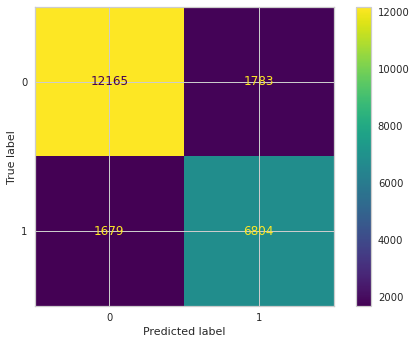

In [114]:
cmd(confusion_matrix(test_target_clf, Y_pred_dtree)).plot()

### Feature Selection - Regression
Feature importance is not defined for the KNN Regression algorithm. There is no easy way to compute the features responsible for regression here. Although not ideal, what could be done is to use Ridge Regression which does have the feature_importances_ attribute. Even in this case though, the feature_importances_ attribute tells us the most important features for the entire model, not specifically the sample we are predicting on. 

However, in our testing, feature selection techniques explored, all resulted in a worse RMSE. We will not be using feature selection techniques on the final KNN regression model. 

In [157]:
# #import the functions and fit to the training set
# start_time = time.time()

# # Ridge Regression used for feature selection for reg
# feat_select_estimator_reg = Ridge(random_state=24) 

# rfecv_reg = RFECV(estimator=feat_select_estimator_reg,
#               cv=cv_reg, 
#               scoring = 'neg_root_mean_squared_error',
#               n_jobs=nj)
    
# rfecv_reg.fit(training_data_reg, training_target_reg.values.ravel())
    
# print(f'Time to run {round(time.time() - start_time,4)} Seconds')
#     # source:
#     # https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python

In [158]:
# print(f'Optimal number of features for regression: {rfecv_reg.n_features_}')
# features_reg = list(training_data_reg.columns[rfecv_reg.support_])
# print(f'Features for regresion: {features_reg}')

Regression Final Model Fit - KNN

In [159]:
reg_knn.fit(training_data_reg, training_target_reg)

KNeighborsRegressor(n_jobs=-1, n_neighbors=7, weights='distance')

Regression Final Model Predictions - KNN

In [160]:
# Get predictions
yhat_knn = reg_knn.predict(test_data_reg)

Regression Final Model RMSE - KNN

In [161]:
rmse_knn_rfecv = np.sqrt(metrics.mean_squared_error(test_target_reg.to_numpy(), yhat_knn))
print("RMSE is:", rmse_knn_rfecv)

RMSE is: 0.9973887788177132


# Deployment

#### How useful is your model for interested parties (i.e., the companies or organizations that might want to use it for prediction)?
Our client, a hotel chain with two properties, can use our predictive classifier as to whether they think a reservation will cancel. They can then use this information to "overbook" a given percentage based on the model's percentage of current reservations that are predicted to cancel.

#### How would you measure the model's value if it was used by these parties?
We could monitor the number of times the model predicted correctly, and directly tie that back to additional reservations and their monetary value. This could be monitored monthly as $XX in revenue due to "overbookings" that wouldn't have happened without the prediction. 

####  How would your deploy your model for interested parties?

In a production environment, it would make sense to have the model run against each new reservation as it comes in, and then classify it as potential cancel or not. This should be as near real time as possible in order to manage inventory properly. 

####  What other data should be collected?
Missing from this data is the obvious PII such as any sort of information related to customer. Obfuscated data would be sufficient, and in fact individual level data might significantly increase the accuracy of the model.

####  How often would the model need to be updated, etc.?
A monthly update on the model should be sufficient. Updates to the model can be made in non-production environments on production level data, and then dedployed as needed. Deployments should only happen at low traffic times. 

# Exceptional Work

### RFECV

In [98]:
#import the functions and fit to the training set
start_time = time.time()

# Classification Task
rfecv_clf = RFECV(clf_decision,
              cv=cv_clf, 
              scoring = 'roc_auc',
              n_jobs=nj)
    


rfecv_clf.fit(training_data_clf, training_target_clf)
print(f'Time to run {round(time.time() - start_time,4)} Seconds')
    # source:
    # https://stackoverflow.com/questions/55609339/how-to-perform-feature-selection-with-gridsearchcv-in-sklearn-in-python

Time to run 16.3887 Seconds


In [99]:
print(f'Optimal number of features for classification: {rfecv_clf.n_features_}')
features_clf=list(training_data_clf.columns[rfecv_clf.support_])
print(f'Features for classification: {features_clf}')

Optimal number of features for classification: 57
Features for classification: ['arrival_date_week_number', 'adults', 'children', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'total_of_special_requests', 'length_of_stay', 'total_revenue', 'country_cancelation_rate', 'hotel_Resort Hotel', 'meal_FB', 'meal_HB', 'meal_SC', 'meal_Undefined', 'market_segment_Complementary', 'market_segment_Corporate', 'market_segment_Direct', 'market_segment_Groups', 'market_segment_Offline TA/TO', 'market_segment_Online TA', 'distribution_channel_Direct', 'distribution_channel_GDS', 'distribution_channel_TA/TO', 'reserved_room_type_B', 'reserved_room_type_C', 'reserved_room_type_D', 'reserved_room_type_E', 'reserved_room_type_F', 'reserved_room_type_G', 'reserved_room_type_H', 'assigned_room_type_B', 'assigned_room_type_C', 'assigned_room_type_D', 'assigned_room_type_E', 'assigned_room_type_F', 'assigned_room_type_G', 'assigned_room_type_H', 'assigned_room_type_I', 'a

### Bagging - Decision Tree and Nearest Centroid ROC
<ul>Decision Tree ROC</ul>

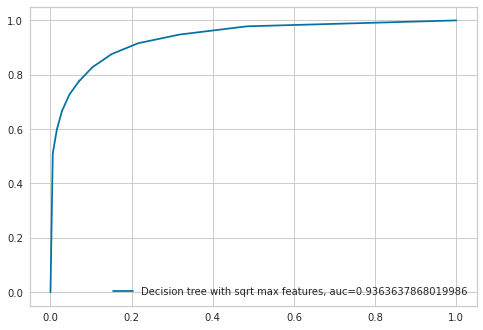

In [85]:
#bagging to get probabilities for an ROC curve for Decision Tree
clf_bag_dtree_acc = BaggingClassifier(base_estimator=clf_decision, 
                                      random_state=24).fit(training_data_clf, training_target_clf)

# plot the ROC curve on the test data for Decision Tree
Y_pred_dtree_acc_prob = clf_bag_dtree_acc.predict_proba(test_data_clf)[::,1]

fpr_dtree_acc, tpr_dtree_acc, _ = metrics.roc_curve(test_target_clf,  Y_pred_dtree_acc_prob)

auc_dtree_acc = metrics.roc_auc_score(test_target_clf, Y_pred_dtree_acc_prob)

plt.plot(fpr_dtree_acc,tpr_dtree_acc,label="Decision tree with sqrt max features, auc="+str(auc_dtree_acc))

plt.legend(loc=4) 

<ul>Nearest Centroid ROC</ul>

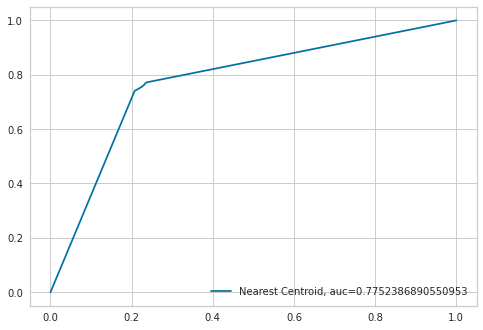

In [86]:
# bagging to get probabilities for an ROC curve for Nearest Centroid
clf_bag_ncent = BaggingClassifier(base_estimator=clf_nearest_cent).fit(training_data_clf, training_target_clf)

# plot the ROC curve on the test data for Nearest Centroid
Y_pred_ncent_prob = clf_bag_ncent.predict_proba(test_data_clf)[::,1]

fpr_ncent, tpr_ncent, _ = metrics.roc_curve(test_target_clf,  Y_pred_ncent_prob)

auc_ncent = metrics.roc_auc_score(test_target_clf, Y_pred_ncent_prob)

plt.plot(fpr_ncent,tpr_ncent,label="Nearest Centroid, auc="+str(auc_ncent))

plt.legend(loc=4) 

### GridSearchCV
Used for classification and regression hyper parameter tuning for KNN, Nearest Centroid, Naive Bayes, Decision Tree, Random Forest, and OLS Ridge Regression

<ul>Example: Nearest Centroid</ul>

In [88]:
time.time()
start_time = time.time()

clf_nearest_cent = NearestCentroid()

# setting the parameters
grid = {}
grid['shrink_threshold'] = arange(0, .01, .1)
grid['metric'] = ['euclidean','manhattan','cosine']

# define search
search_f1 = GridSearchCV(clf_nearest_cent, grid, scoring='f1', cv=cv_clf, n_jobs=nj, verbose=1)

# perform the search
results_f1_nc = search_f1.fit(training_data_clf, training_target_clf.values.ravel())

# summarize the results
print('Mean f1: %.3f' % results_f1_nc.best_score_)
print('Config f1: %s' % results_f1_nc.best_params_)

print(f'Best estimator: {results_f1_nc.best_estimator_}\n')

print(f'Time to run {round(time.time() - start_time,4)} Seconds')

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:    1.9s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:    2.1s finished


Mean f1: 0.710
Config f1: {'metric': 'cosine', 'shrink_threshold': 0.0}
Best estimator: NearestCentroid(metric='cosine', shrink_threshold=0.0)

Time to run 2.2391 Seconds


### Advanced Feature Engineering
Calculated the per country cancelation rate and joined it back to the original data at the reservation level.

```python
# add `country_cancelation_rate`
    # first we aggregate number of cancelations per country, then divide by total records per country
    # once we have the rate, we join back on country name
hotel['is_canceled_int'] = pd.to_numeric(hotel['is_canceled'])

contry_cancellation_rate_df = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].count())

contry_cancellation_rate_df.columns = ['country_count']
contry_cancellation_rate_df['cancelations'] = pd.DataFrame(hotel.groupby(['country'])['is_canceled_int'].sum())

contry_cancellation_rate_df['country_cancelation_rate'] = contry_cancellation_rate_df['cancelations'] / contry_cancellation_rate_df['country_count']

hotel = hotel.join(contry_cancellation_rate_df, on='country')

total_cancelations = hotel.is_canceled_int.sum()
````